In [1]:
import importlib
import os
import sys
sys.path.append('/home/gpuvmadm/PyTomography/src')
import numpy as np
import pytomography
from misc import get_organ_masks, get_organ_volume, get_photopeak_scatter
import torch
import recon_script
importlib.reload(recon_script)
import sys
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from pytomography.priors import RelativeDifferencePrior, AnatomyNeighbourWeight, TopNAnatomyNeighbourWeight
from pytomography.io.SPECT import simind
import pickle
pytomography.device = device

/tmp/ipykernel_9021/3487926038.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


Types of reconstructions to be done

In [5]:
organ_specifications_path = '/disk1/pytomography_paper_results/data/organ_specifications.csv'
organ_concentrations_path = '/disk1/pytomography_paper_results/data/organ_concentrations.csv'
organ_concentrations_indices = [5]
recon_types = ['regular']
scatter_types = ['TEW']
CT = simind.get_atteuation_map(os.path.join('/disk1/EANM2023/mu208.hct'))[:,:,128:256]
#prior_weight = AnatomyNeighbourWeight(CT, lambda CT, CT_n: 1/(1+1e4*(CT-CT_n)**2))
#priors = [None, RelativeDifferencePrior(beta=0.3, gamma=2), RelativeDifferencePrior(beta=0.3, gamma=2, weight=prior_weight)]
#prior_names = ['no_prior', 'rdp_beta0.3_gamma2', 'ana_rdp_beta0.3_gamma2']
prior_weight = TopNAnatomyNeighbourWeight(CT, 8)
priors = [RelativeDifferencePrior(beta=0.3, gamma=2, weight=prior_weight)]
prior_names = ['ana8nearest_rdp_beta0.3_gamma2']
organ_segmentation_type = 'GT'
projection_times = [15]
CPSperMBq = 11.7284
n_iters = 120
#n_iters = 8

Open up 
* Object meta for reconstruction
* Masks/mask volumes needed to get activities in the callback

In [6]:
object_meta, _, _, _ = get_photopeak_scatter(organ_specifications_path, organ_concentrations_path, 0, dT=1, headerfile_peak='photopeak.h00', headerfile_lower='lowerscatter.h00', headerfile_upper='upperscatter.h00')
masks = get_organ_masks(organ_specifications_path, object_meta, full_voxel=True)
_, _, GT_paths, _, _ = np.genfromtxt(organ_specifications_path, delimiter=',', skip_header=3, dtype=str).T
GT_dz, GT_dy, GT_dx = np.genfromtxt(organ_specifications_path, delimiter=',', skip_header=1, max_rows=1).T
mask_volumes = np.vectorize(get_organ_volume)(GT_paths, GT_dx*GT_dy*GT_dz)

Run all reconstructions and save the data

In [7]:
for organ_concentrations_index in organ_concentrations_indices:
    for recon_type in recon_types:
        for scatter_type in scatter_types:
            for projection_time in projection_times:
                for prior, prior_name in zip(priors, prior_names):
                    save_path = f'/disk1/pytomography_paper_results/IIIB/{organ_concentrations_path.split("/")[-1][:-4]}_{organ_concentrations_index}_recon{recon_type}_scat{scatter_type}_dT{projection_time}_masks{organ_segmentation_type}_niters{n_iters}_priors_{prior_name}'
                    recon_script.reconstruct_phantom(organ_specifications_path, organ_concentrations_path, organ_concentrations_index, recon_type, scatter_type, organ_segmentation_type, projection_time, CPSperMBq, n_iters, prior=prior, masks=masks, mask_volumes=mask_volumes, save_path=save_path, save_recon_object=True)

/home/gpuvmadm/PyTomography/src/pytomography/io/SPECT/helpers.py:43: RuntimeWarning: overflow encountered in exp
  return c1*np.exp(-d1*np.sqrt(energy)) + c2*np.exp(-d2*np.sqrt(energy))


# Plotting

In [2]:
test_noprior = np.load('/disk1/pytomography_paper_results/IIIB/organ_concentrations_5_reconregular_scatTEW_dT15_masksGT_niters120_priors_no_prior_object.npy')
test_noprior_iter8 = np.load('/disk1/pytomography_paper_results/IIIB/organ_concentrations_5_reconregular_scatTEW_dT15_masksGT_niters8_priors_no_prior_object.npy')
test_noprior_stats = np.load('/disk1/pytomography_paper_results/IIIB/organ_concentrations_5_reconregular_scatTEW_dT15_masksGT_niters120_priors_no_prior.npz')
test_prior = np.load('/disk1/pytomography_paper_results/IIIB/organ_concentrations_5_reconregular_scatTEW_dT15_masksGT_niters120_priors_rdp_beta0.3_gamma2_object.npy')
test_prior_stats = np.load('/disk1/pytomography_paper_results/IIIB/organ_concentrations_5_reconregular_scatTEW_dT15_masksGT_niters120_priors_rdp_beta0.3_gamma2.npz')
test_prior_ap = np.load('/disk1/pytomography_paper_results/IIIB/organ_concentrations_5_reconregular_scatTEW_dT15_masksGT_niters120_priors_ana8nearest_rdp_beta0.3_gamma2_object.npy')
test_prior_ap_stats = np.load('/disk1/pytomography_paper_results/IIIB/organ_concentrations_5_reconregular_scatTEW_dT15_masksGT_niters120_priors_ana8nearest_rdp_beta0.3_gamma2.npz')

In [3]:
test_noprior_stats['labels']

array(['bkg', 'liver', 'r_lung', 'l_lung', 'r_kidney_cortex',
       'r_kidney_medulla', 'l_kidney_cortex', 'l_kidney_medulla',
       'salivary', 'bladder'], dtype='<U58')

In [4]:
test_noprior_stats['activity_concs_pct'].T[-1]

array([ 98.89936698, 104.18267458, 135.82820692, 110.74088095,
       108.46608772, 177.9919365 , 105.09752459, 130.41935061,
       114.70886335, 111.87017845])

In [5]:
test_prior_stats['activity_concs_pct'].T[-1]

array([100.38002371,  99.66833597, 209.74181214, 185.64902262,
        87.13045904, 198.07204208,  80.99090727, 167.57133334,
        98.30924664, 105.50217159])

In [6]:
test_prior_ap_stats['activity_concs_pct'].T[-1]

array([ 98.87096897,  99.42189665, 121.01911394, 108.53791371,
        90.80085385, 167.37351139,  90.69417781, 146.44386444,
        98.01160531, 103.62793717])

In [7]:
def plot_bvc(stats, organ, ax, color, label, iter_n=None):
    idx = np.argmax(stats['labels']==organ)
    idx_liver = np.argmax(stats['labels']=='liver')
    bias_pct = stats['activity_concs_pct'][idx] - 100
    noise_liver_pct = stats['activity_concs_pct_noise'][idx_liver]
    ax.plot(bias_pct, noise_liver_pct, markersize=4, lw=2, color=color, label=label)
    ax.plot(bias_pct[0], noise_liver_pct[0], ls='--', marker='s', markersize=8, lw=2, color=color)
    if iter_n is not None:
        ax.plot(bias_pct[iter_n], noise_liver_pct[iter_n], ls='--', marker='*', markersize=8, lw=2, color=color)

def plot_object(ob, ax, mode='color', vmax_set=None):
    if mode=='color':
        tcol = 'white'
        cmap = 'nipy_spectral'
        vmax = 1
    elif mode=='bw':
        tcol = 'red'
        cmap = 'Greys'
        vmax = 0.15
    if vmax_set is not None:
        vmax=None
    im = ax.pcolormesh(ob[:,64].T, cmap=cmap, vmax=vmax)
    #ax.axis('off')
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    return im

organs_ = ['l_lung', 'liver', 'r_kidney_medulla', 'r_kidney_cortex', 'salivary', 'bladder']
title_dict = {'l_lung': 'Lungs', 'liver': 'Liver', 'r_kidney_medulla': 'Kidney Medulla', 'r_kidney_cortex': 'Kidney Cortex', 'salivary': 'Salivary Glands', 'bladder': 'Bladder'}

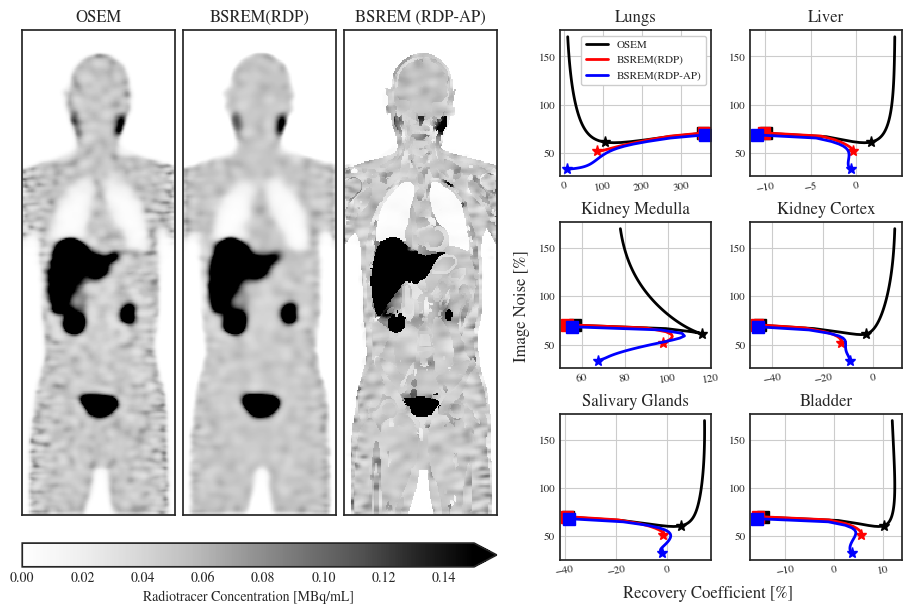

In [11]:
mode = 'bw'

fig = plt.figure(constrained_layout=True, figsize=(9,6))
(subfig_l, subfig_r) = fig.subfigures(nrows=1, ncols=2, width_ratios=(0.75,0.6))
axes_l = subfig_l.subplots(nrows=1, ncols=3)
axes_l[0].set_title('OSEM')
axes_l[1].set_title('BSREM(RDP)')
axes_l[2].set_title('BSREM (RDP-AP)')
im = plot_object(test_noprior_iter8, axes_l[0], mode=mode)
plot_object(test_prior, axes_l[1], mode=mode)
plot_object(test_prior_ap, axes_l[2], mode=mode)
subfig_l.colorbar(im, ax=axes_l, location='bottom', label='Radiotracer Concentration [MBq/mL]', extend='max')

#Noise bias curves
axes_r = subfig_r.subplots(nrows=3, ncols=2)
for ax, organ in zip(axes_r.ravel(), organs_):
    plot_bvc(test_noprior_stats, organ, ax, 'k', 'OSEM', iter_n=7)
    plot_bvc(test_prior_stats, organ, ax, 'r', 'BSREM(RDP)', iter_n=-1)
    plot_bvc(test_prior_ap_stats, organ, ax, 'b', 'BSREM(RDP-AP)', iter_n=-1)
    ax.grid()
    ax.tick_params(axis='y', which='major', labelsize=8)
    ax.tick_params(axis='x', which='major', labelsize=8, rotation=10)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.set_title(title_dict[organ])
axes_r[0,0].legend(facecolor='white', framealpha=1, frameon=True, loc='upper right', fontsize=8)
subfig_r.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
subfig_r.supylabel('Image Noise [%]')
subfig_r.supxlabel('Recovery Coefficient [%]')

plt.savefig('IIIB_results.png', bbox_inches='tight', dpi=300)